<a href="https://www.kaggle.com/code/yannicksteph/nlp-stemming-lemmatization-classification?scriptVersionId=166612494" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

In [2]:
nltk.download("wordnet")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2024-03-12 09:30:53--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: 'bbc_text_cls.csv'

bbc_text_cls.csv    100%[===================>]   4.85M  5.44MB/s    in 0.9s    

2024-03-12 09:30:55 (5.44 MB/s) - 'bbc_text_cls.csv' saved [5085081/5085081]



In [5]:
df = pd.read_csv('/kaggle/input/nlp-news-article/bbc_text_cls.csv')


In [6]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [7]:
len(df)

2225

In [8]:
inputs = df['text']
labels = df['labels']

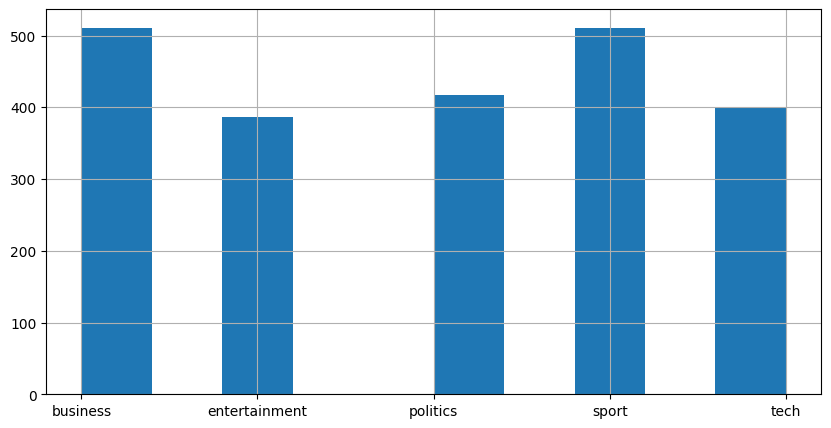

In [9]:
labels.hist(figsize=(10, 5));

# Training

In [10]:
inputs_train, inputs_test, Ytrain, Ytest = train_test_split(inputs, labels, random_state=123)

In [11]:
vectorizer = CountVectorizer()

In [12]:
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)

In [13]:
Xtrain

<1668x26287 sparse matrix of type '<class 'numpy.int64'>'
	with 337411 stored elements in Compressed Sparse Row format>

In [14]:
# counts the number of non-zero elements in the array Xtrain. 
# in determining sparsity or understanding the distribution of non-zero values in a dataset.
(Xtrain != 0).sum()

337411

In [15]:
# what percentage of values are non-zero?
(Xtrain != 0).sum() / np.prod(Xtrain.shape)

0.007695239935415004

# Normal Training

In [16]:
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.9922062350119905
test score: 0.9712746858168761


# With stopwords Training

In [17]:
# with stopwords
vectorizer = CountVectorizer(stop_words='english')
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.9928057553956835
test score: 0.9766606822262118


# With Lemmatization Training

POS (Part of Speech) tags. We add a tag with a particular word defining its type (verb, noun, adjective etc).

In [18]:
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

In [19]:
class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    words_and_tags = nltk.pos_tag(tokens)
    return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) \
            for word, tag in words_and_tags]

In [20]:
# with lemmatization
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9922062350119905
test score: 0.9676840215439856


# With Stemming Training

In [21]:
class StemTokenizer:
  def __init__(self):
    self.porter = PorterStemmer()
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    return [self.porter.stem(t) for t in tokens]

In [22]:
# with stemming
vectorizer = CountVectorizer(tokenizer=StemTokenizer())
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9892086330935251
test score: 0.9694793536804309


# With Simple tokenizer

In [23]:
def simple_tokenizer(s):
  return s.split()

In [24]:
# string split tokenizer
vectorizer = CountVectorizer(tokenizer=simple_tokenizer)
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


train score: 0.9952038369304557
test score: 0.9712746858168761
